<a href="https://colab.research.google.com/github/boom-bam-boop/Basic-GAN/blob/main/Basic_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch, pdb
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import torch.nn as nn
import os
import tensorflow as tf


In [ ]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

Visualization

In [ ]:
def show(tensor, ch=1, size =(28, 28),  num=16 ):
    data = tensor.detach().cpu().view(-1, ch, *size)#128 x 1 x 28 x 28
    grid = make_grid(data[:num], nrow = 4 ).permute(1, 2, 0) #1 x 28 x 28 --> 28 x 28 x 1
    plt.imshow(grid)
    plt.show()


In [ ]:
cycles = 50
cur_step = 0
info_step = 300
mean_gen_loss = 0
mean_disc_loss = 0


z_dim = 64
lr = 0.0001
loss_func = torch.nn.BCEWithLogitsLoss()

bs = 128
device = 'cuda'

dataloader = DataLoader(MNIST('.', download = True, transform = transforms.ToTensor()), batch_size = bs, shuffle = True)



Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.43MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.92MB/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



Generator

In [ ]:
def genBlock(inp, out):
    return nn.Sequential(nn.Linear(inp, out),nn.BatchNorm1d(out), nn.LeakyReLU(0.2))

class Generator(nn.Module):
  def __init__(self, z_dim = 64, i_dim = 784, h_dim = 128):
    super().__init__()
    self.gen = nn.Sequential(genBlock(z_dim, h_dim),
                             genBlock(h_dim, h_dim*2),
                             genBlock(h_dim*2, h_dim*4),
                             genBlock(h_dim*4, h_dim*8),
                             nn.Linear(h_dim*8, i_dim),
                             nn.Sigmoid())

  def forward(self, noise):
    return self.gen(noise)

def gen_noise(number, z_dim):
  return torch.randn(number, z_dim).to(device)




Discriminator

In [ ]:
def discBlock(inp, out):
  return nn.Sequential(nn.Linear(inp, out),nn.LeakyReLU(0.2))

class Discriminator(nn.Module):
  def __init__(self, z_dim = 64, i_dim = 784, h_dim = 128):
    super().__init__()
    self.disc = nn.Sequential(discBlock(i_dim, h_dim*5),
                              discBlock(h_dim*5, h_dim*3),
                              discBlock(h_dim*3, h_dim),
                              nn.Linear(h_dim, 1)
                              )
  def forward(self, image):
    return self.disc(image)

In [ ]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.RMSprop(gen.parameters(), lr = lr)
disc = Discriminator().to(device)
disc_opt = torch.optim.RMSprop(disc.parameters(), lr = lr)


Generator Loss

In [ ]:
def gen_loss(z_dim, gen, disc, bs, loss_func):
  return loss_func(disc(gen(gen_noise(bs, z_dim))), torch.ones_like(disc(gen(gen_noise(bs, z_dim)))))

Discriminator Loss

In [ ]:
def disc_loss(z_dim, gen, disc, bs, loss_func, real):
  fake_pred = disc((gen(gen_noise(bs, z_dim))).detach())
  real_pred = disc(real)
  fake_loss = loss_func(fake_pred, torch.zeros_like(fake_pred))
  real_loss = loss_func(real_pred, torch.ones_like(real_pred))
  return (fake_loss + real_loss)/2


Main Training Loop

  0%|          | 0/469 [00:00<?, ?it/s]

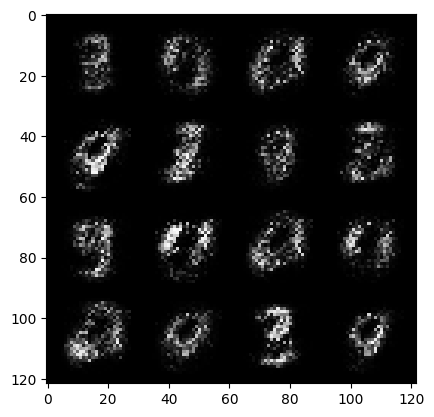

0 : step 300, Generator loss : 1.4091951203346267, Discriminator Loss : 0.36594587152202945


  0%|          | 0/469 [00:00<?, ?it/s]

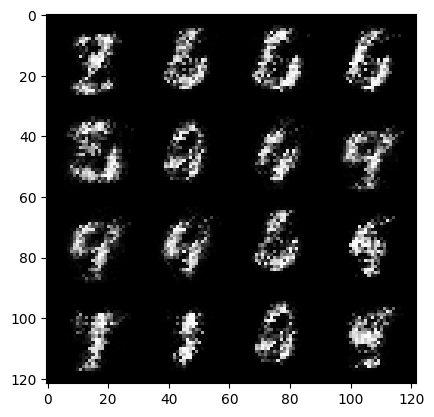

1 : step 600, Generator loss : 1.5837275922298435, Discriminator Loss : 0.3822461573282876


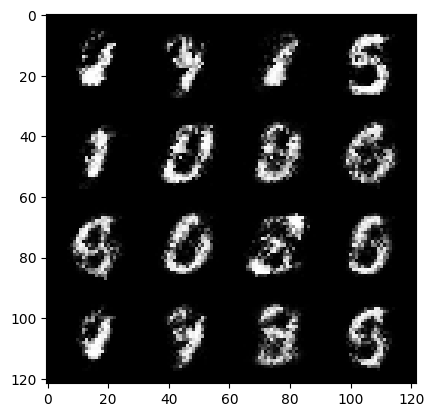

1 : step 900, Generator loss : 1.560960604747137, Discriminator Loss : 0.4495782990256942


  0%|          | 0/469 [00:00<?, ?it/s]

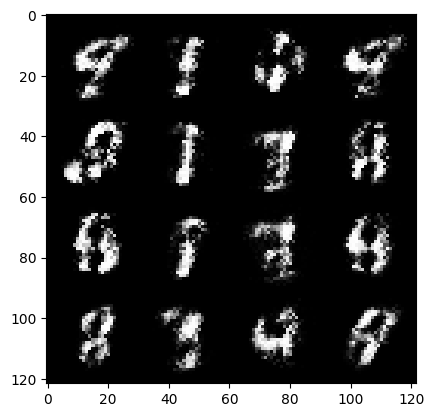

2 : step 1200, Generator loss : 1.386348766684533, Discriminator Loss : 0.5000479290882748


  0%|          | 0/469 [00:00<?, ?it/s]

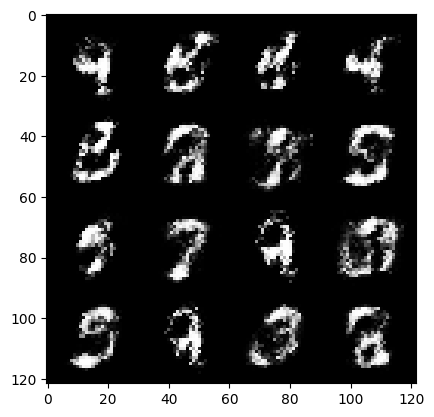

3 : step 1500, Generator loss : 1.3586826730767887, Discriminator Loss : 0.5034287839134535


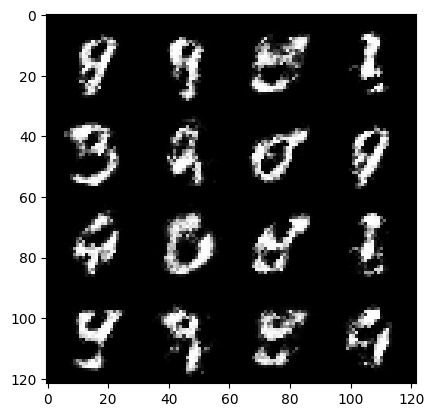

3 : step 1800, Generator loss : 1.2658572127421712, Discriminator Loss : 0.5374328065911929


  0%|          | 0/469 [00:00<?, ?it/s]

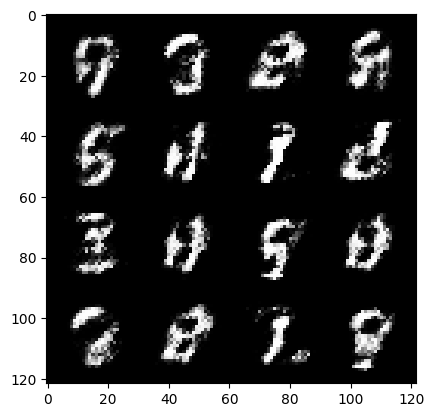

4 : step 2100, Generator loss : 1.1966617165009186, Discriminator Loss : 0.5443709501624101


  0%|          | 0/469 [00:00<?, ?it/s]

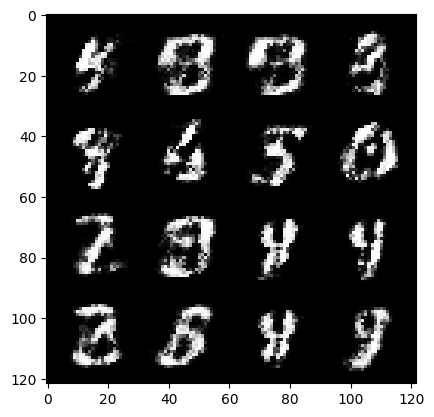

5 : step 2400, Generator loss : 1.207904628713926, Discriminator Loss : 0.534451189438502


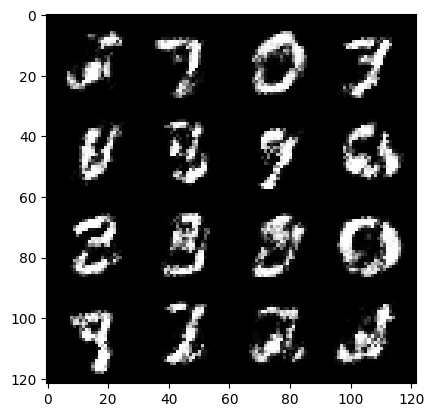

5 : step 2700, Generator loss : 1.177793573339779, Discriminator Loss : 0.5478282602628072


  0%|          | 0/469 [00:00<?, ?it/s]

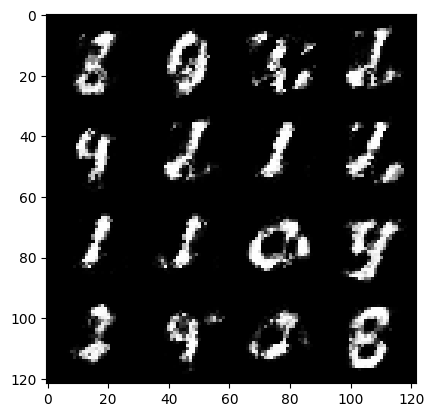

6 : step 3000, Generator loss : 1.1661026736100517, Discriminator Loss : 0.5435029565294583


  0%|          | 0/469 [00:00<?, ?it/s]

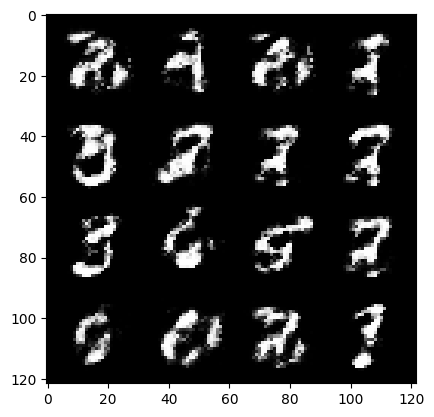

7 : step 3300, Generator loss : 1.165576202670733, Discriminator Loss : 0.5422499462962154


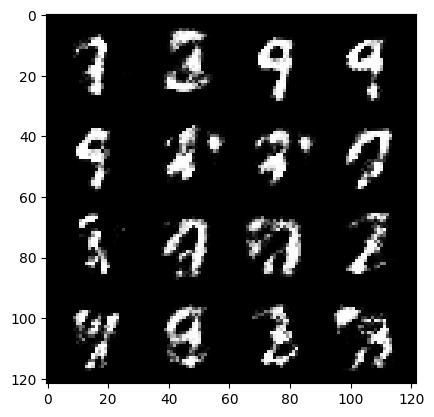

7 : step 3600, Generator loss : 1.1407655539115271, Discriminator Loss : 0.5478861009081205


  0%|          | 0/469 [00:00<?, ?it/s]

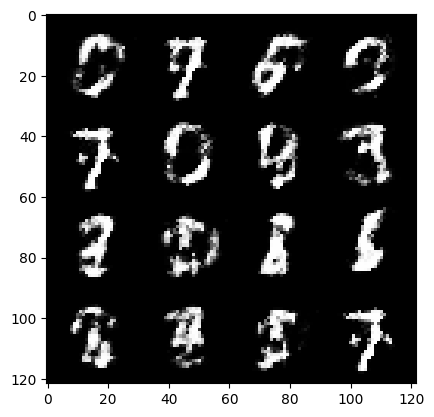

8 : step 3900, Generator loss : 1.1441273351510362, Discriminator Loss : 0.5439294312397638


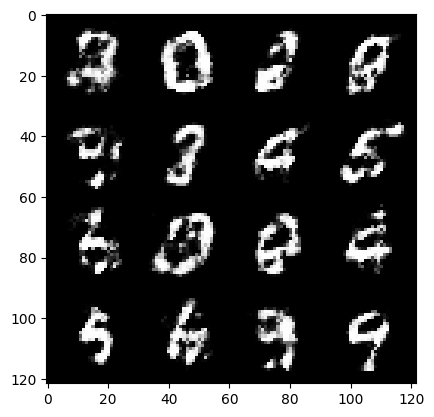

8 : step 4200, Generator loss : 1.189553159872691, Discriminator Loss : 0.5275766824682554


  0%|          | 0/469 [00:00<?, ?it/s]

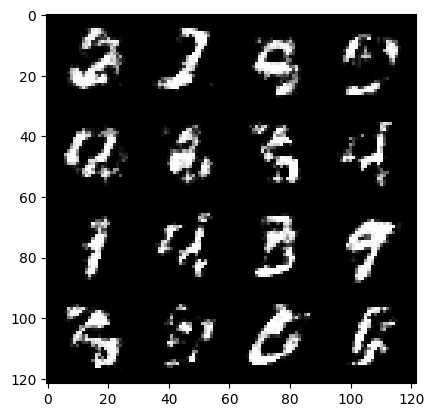

9 : step 4500, Generator loss : 1.160970788598061, Discriminator Loss : 0.54030001660188


  0%|          | 0/469 [00:00<?, ?it/s]

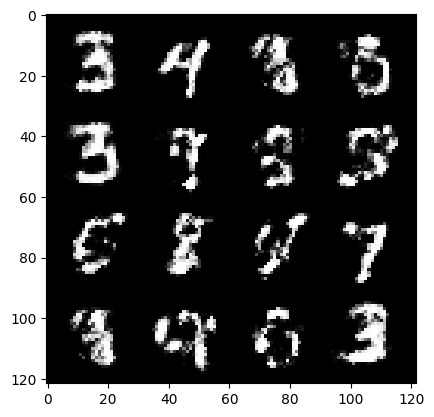

10 : step 4800, Generator loss : 1.1571764773130415, Discriminator Loss : 0.5335580903291703


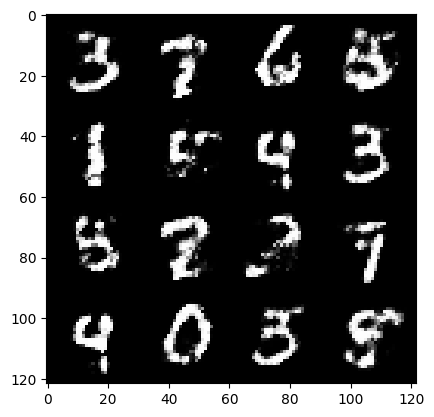

10 : step 5100, Generator loss : 1.1954078155755994, Discriminator Loss : 0.5240038362145425


  0%|          | 0/469 [00:00<?, ?it/s]

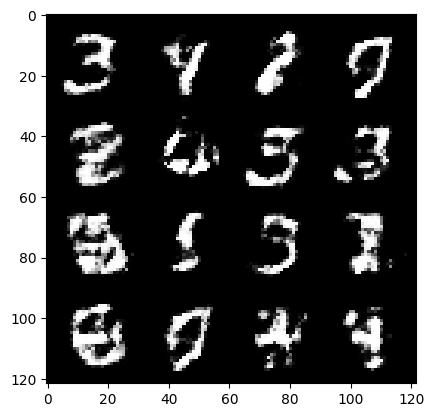

11 : step 5400, Generator loss : 1.1553420152266833, Discriminator Loss : 0.5354093016187347


  0%|          | 0/469 [00:00<?, ?it/s]

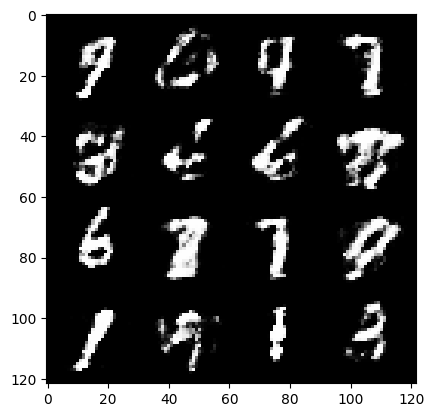

12 : step 5700, Generator loss : 1.1263125322262448, Discriminator Loss : 0.5458400902152062


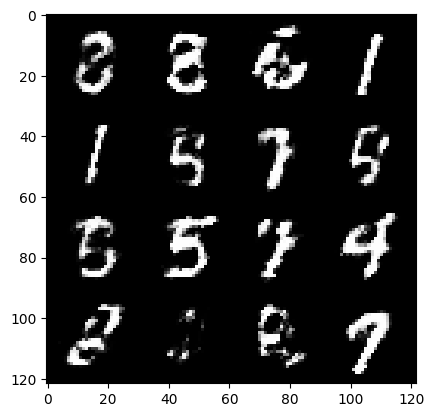

12 : step 6000, Generator loss : 1.100627046227455, Discriminator Loss : 0.5546338959534967


  0%|          | 0/469 [00:00<?, ?it/s]

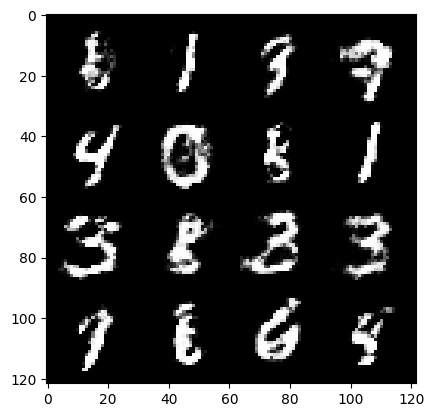

13 : step 6300, Generator loss : 1.0840967647234592, Discriminator Loss : 0.5602459632356959


  0%|          | 0/469 [00:00<?, ?it/s]

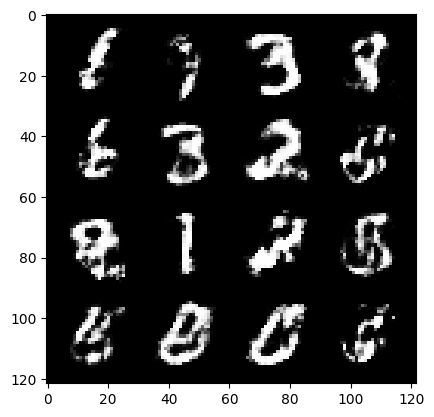

14 : step 6600, Generator loss : 1.0912583941221237, Discriminator Loss : 0.5584097323815026


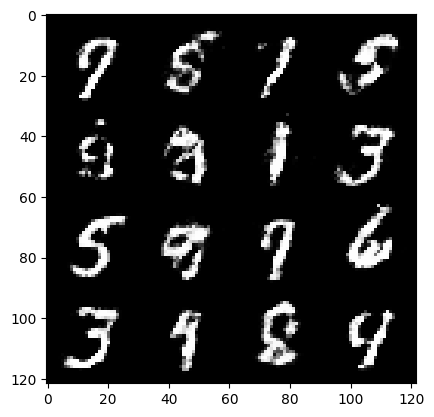

14 : step 6900, Generator loss : 1.1052855203549068, Discriminator Loss : 0.5516136035323144


  0%|          | 0/469 [00:00<?, ?it/s]

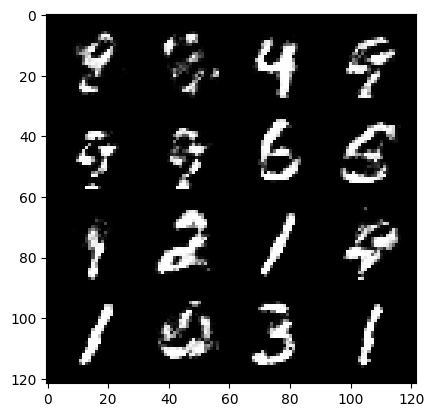

15 : step 7200, Generator loss : 1.0964389447371152, Discriminator Loss : 0.5527142071723938


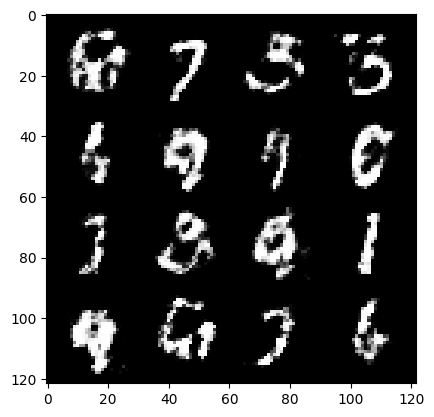

15 : step 7500, Generator loss : 1.0834620130062111, Discriminator Loss : 0.5542952434221903


  0%|          | 0/469 [00:00<?, ?it/s]

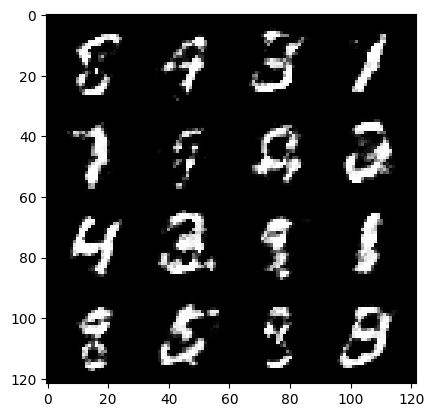

16 : step 7800, Generator loss : 1.0814435138305023, Discriminator Loss : 0.560206082562605


  0%|          | 0/469 [00:00<?, ?it/s]

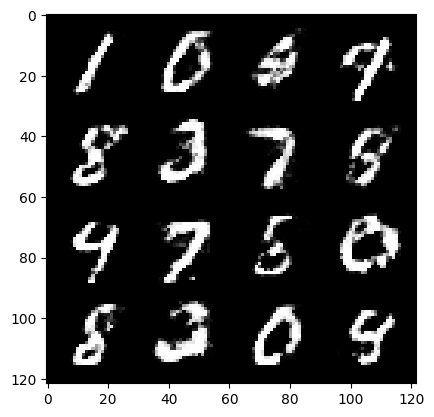

17 : step 8100, Generator loss : 1.0964390665292745, Discriminator Loss : 0.5510443352659541


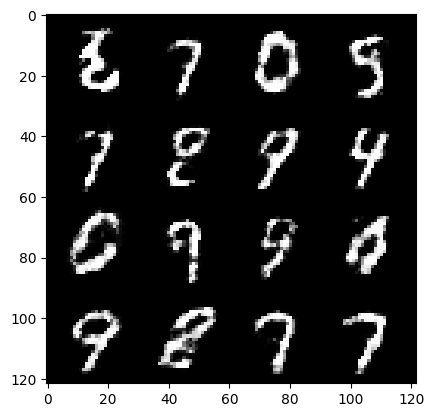

17 : step 8400, Generator loss : 1.0961402968565628, Discriminator Loss : 0.5509365234772363


  0%|          | 0/469 [00:00<?, ?it/s]

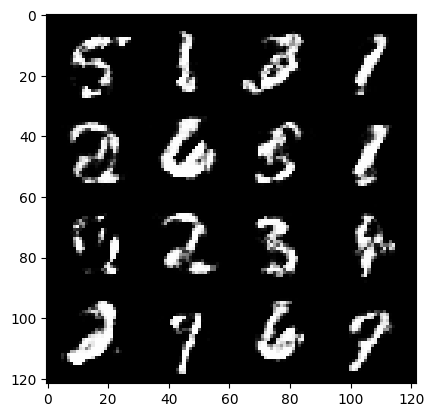

18 : step 8700, Generator loss : 1.1158857667446136, Discriminator Loss : 0.5451356498400374


  0%|          | 0/469 [00:00<?, ?it/s]

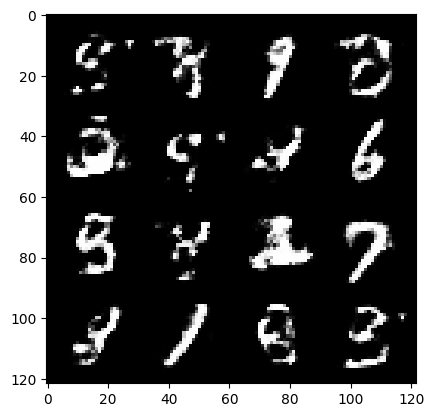

19 : step 9000, Generator loss : 1.1390301165978118, Discriminator Loss : 0.5377292401591942


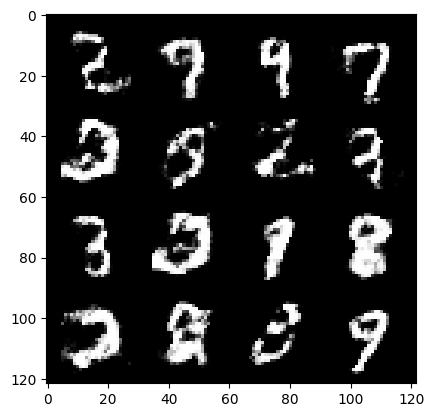

19 : step 9300, Generator loss : 1.1347263618310293, Discriminator Loss : 0.5390928195913635


  0%|          | 0/469 [00:00<?, ?it/s]

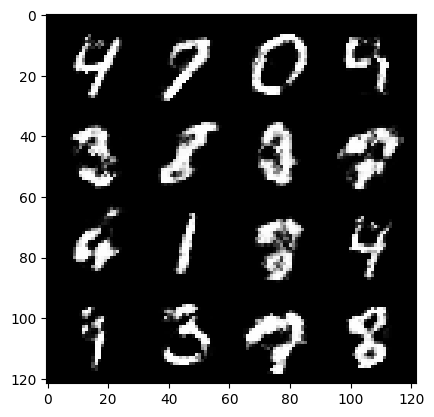

20 : step 9600, Generator loss : 1.158166034619015, Discriminator Loss : 0.5301665787895518


  0%|          | 0/469 [00:00<?, ?it/s]

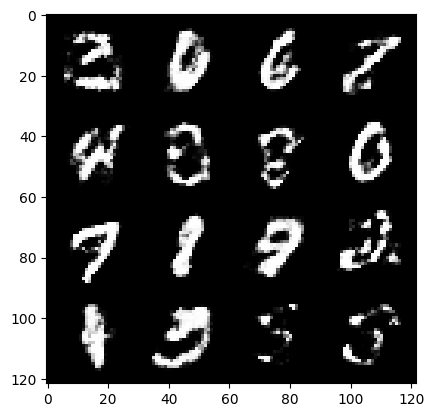

21 : step 9900, Generator loss : 1.1871891933679588, Discriminator Loss : 0.5224008798599244


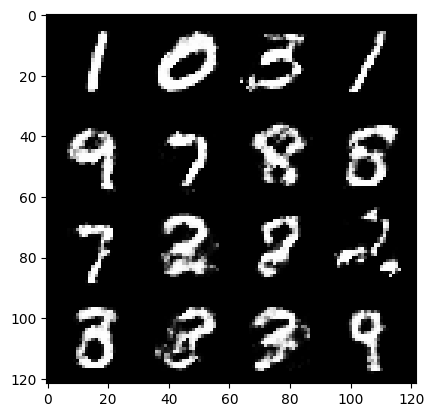

21 : step 10200, Generator loss : 1.194250438610712, Discriminator Loss : 0.5232086815436682


  0%|          | 0/469 [00:00<?, ?it/s]

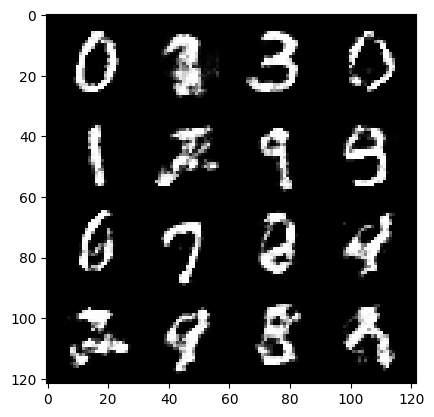

22 : step 10500, Generator loss : 1.2139500383536028, Discriminator Loss : 0.5140314538280167


  0%|          | 0/469 [00:00<?, ?it/s]

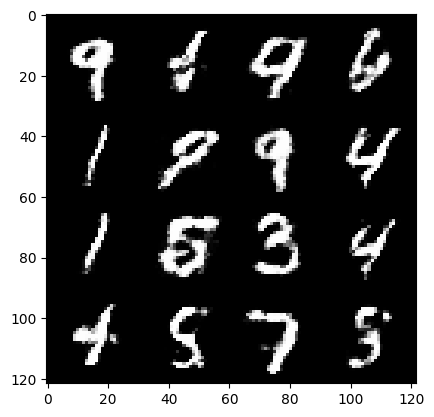

23 : step 10800, Generator loss : 1.2414190022150675, Discriminator Loss : 0.5114276874065402


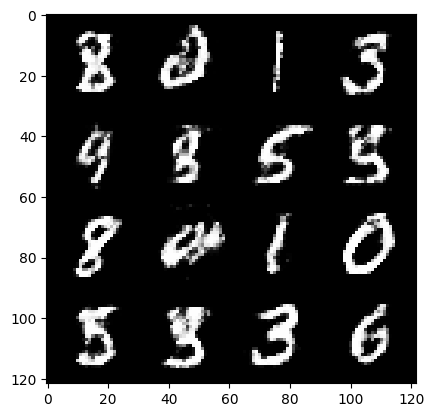

23 : step 11100, Generator loss : 1.2600199800729754, Discriminator Loss : 0.5042597616712252


  0%|          | 0/469 [00:00<?, ?it/s]

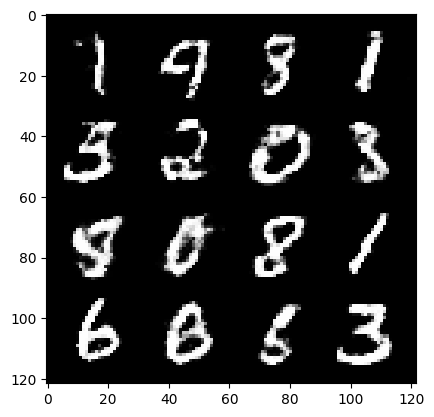

24 : step 11400, Generator loss : 1.2791263947884242, Discriminator Loss : 0.4970236390829086


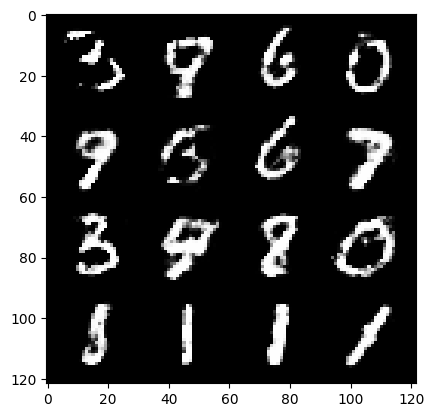

24 : step 11700, Generator loss : 1.2876241066058483, Discriminator Loss : 0.4953329607844355


  0%|          | 0/469 [00:00<?, ?it/s]

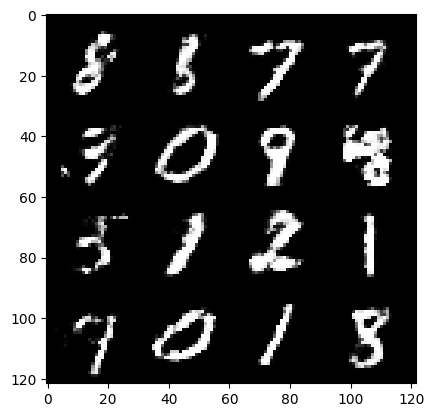

25 : step 12000, Generator loss : 1.3212705932060869, Discriminator Loss : 0.4832433846592904


  0%|          | 0/469 [00:00<?, ?it/s]

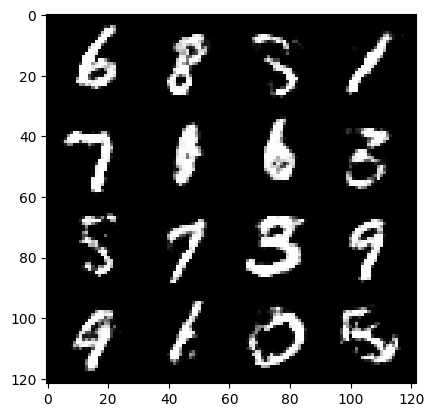

26 : step 12300, Generator loss : 1.3491861031452816, Discriminator Loss : 0.4763865139087043


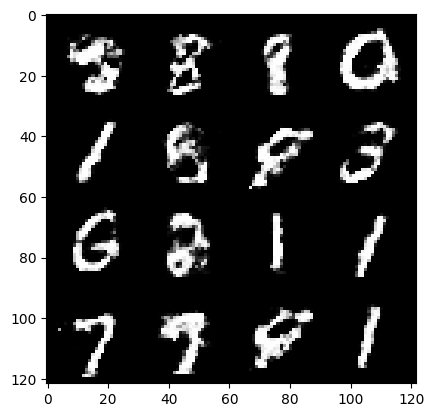

26 : step 12600, Generator loss : 1.3774217224121097, Discriminator Loss : 0.47280682732661594


  0%|          | 0/469 [00:00<?, ?it/s]

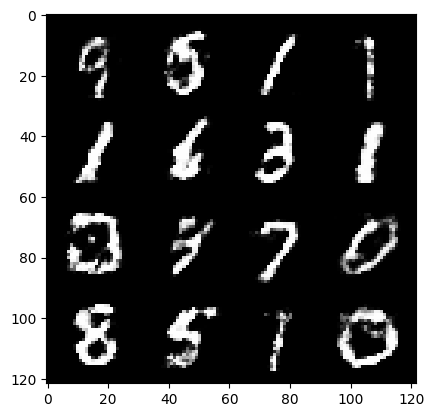

27 : step 12900, Generator loss : 1.3588091925779964, Discriminator Loss : 0.47248277554909335


  0%|          | 0/469 [00:00<?, ?it/s]

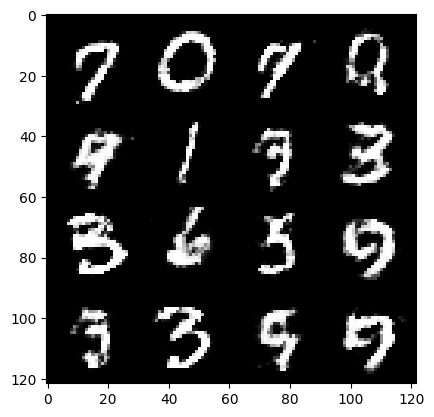

28 : step 13200, Generator loss : 1.4112868724266692, Discriminator Loss : 0.4644385372598965


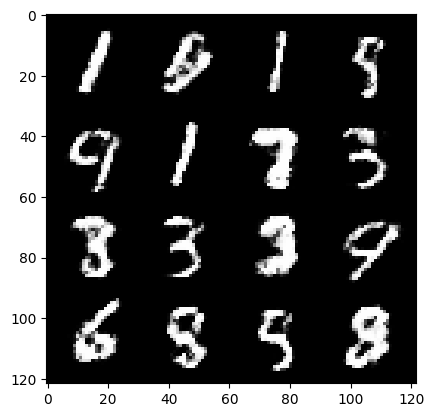

28 : step 13500, Generator loss : 1.40495057284832, Discriminator Loss : 0.46241256882747006


  0%|          | 0/469 [00:00<?, ?it/s]

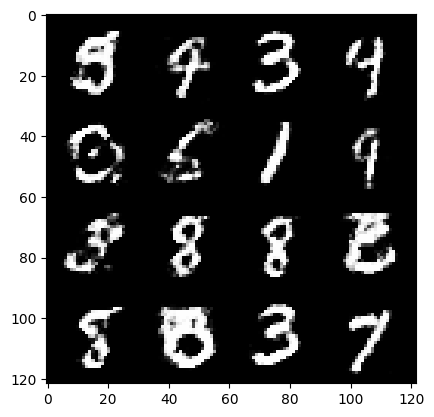

29 : step 13800, Generator loss : 1.4359421861171722, Discriminator Loss : 0.4543331547578177


  0%|          | 0/469 [00:00<?, ?it/s]

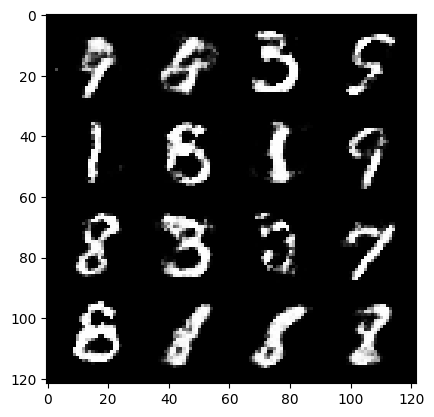

30 : step 14100, Generator loss : 1.4205471883217484, Discriminator Loss : 0.4596464255452156


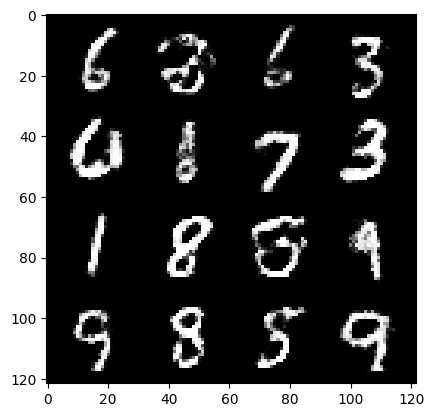

30 : step 14400, Generator loss : 1.4636695309480037, Discriminator Loss : 0.44843353539705266


  0%|          | 0/469 [00:00<?, ?it/s]

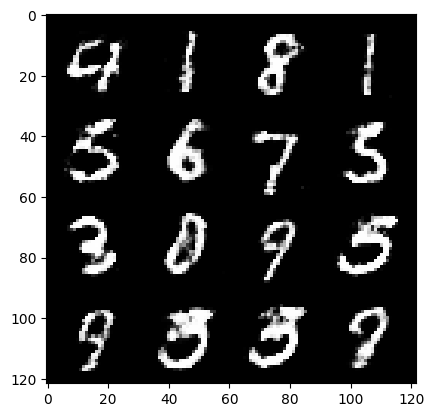

31 : step 14700, Generator loss : 1.5013765811920157, Discriminator Loss : 0.444428998728593


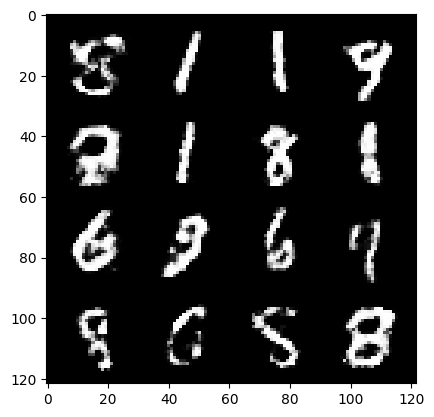

31 : step 15000, Generator loss : 1.5163737614949546, Discriminator Loss : 0.4363527663548786


  0%|          | 0/469 [00:00<?, ?it/s]

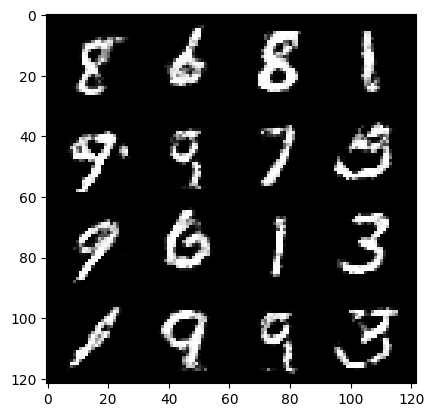

32 : step 15300, Generator loss : 1.5369413203001032, Discriminator Loss : 0.4291765572627387


  0%|          | 0/469 [00:00<?, ?it/s]

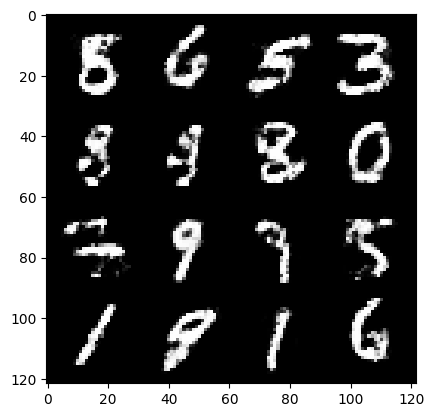

33 : step 15600, Generator loss : 1.52416860918204, Discriminator Loss : 0.43705984055995917


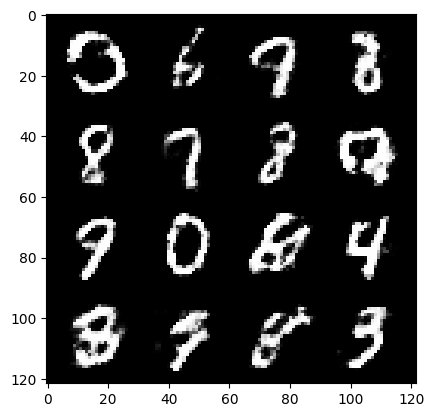

33 : step 15900, Generator loss : 1.5656984663009648, Discriminator Loss : 0.42848716735839865


  0%|          | 0/469 [00:00<?, ?it/s]

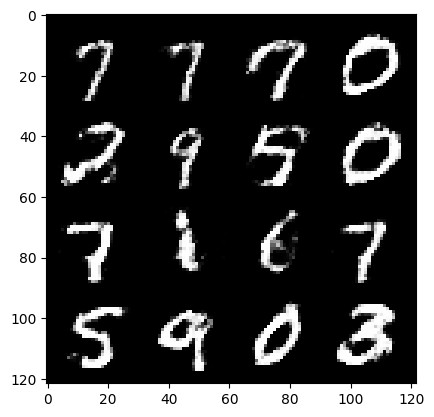

34 : step 16200, Generator loss : 1.5908983405431114, Discriminator Loss : 0.42030701210101457


  0%|          | 0/469 [00:00<?, ?it/s]

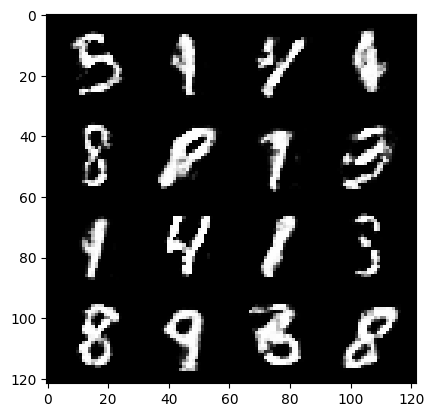

35 : step 16500, Generator loss : 1.5986551658312471, Discriminator Loss : 0.419094034632047


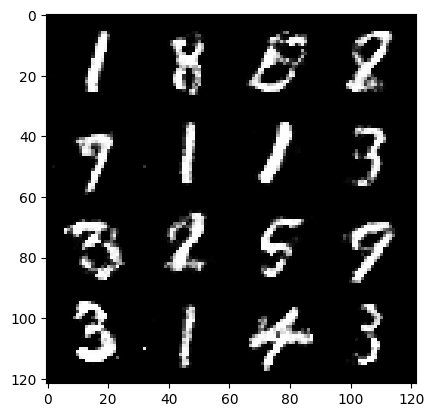

35 : step 16800, Generator loss : 1.6049517126878106, Discriminator Loss : 0.4213720799485839


  0%|          | 0/469 [00:00<?, ?it/s]

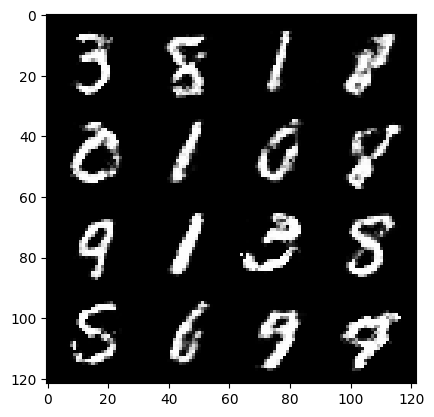

36 : step 17100, Generator loss : 1.6116965820391982, Discriminator Loss : 0.41942226906617514


  0%|          | 0/469 [00:00<?, ?it/s]

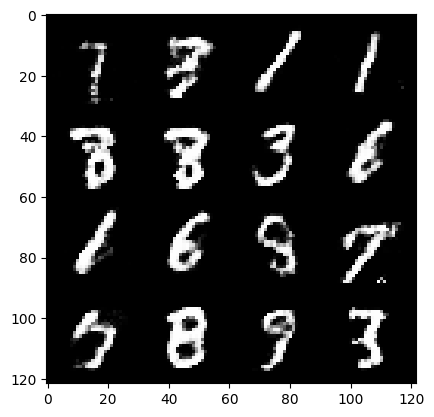

37 : step 17400, Generator loss : 1.6607850354909894, Discriminator Loss : 0.4110456198453902


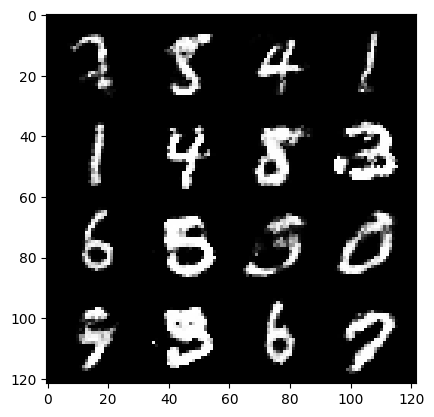

37 : step 17700, Generator loss : 1.659015635649363, Discriminator Loss : 0.40951061606407163


  0%|          | 0/469 [00:00<?, ?it/s]

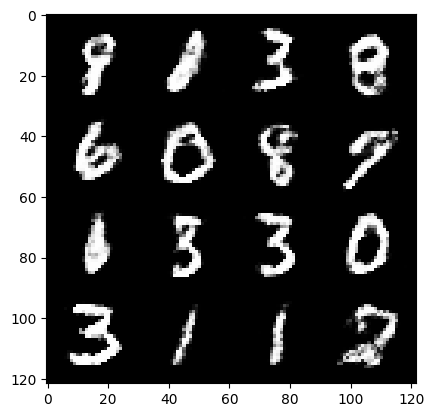

38 : step 18000, Generator loss : 1.6979613292217248, Discriminator Loss : 0.39755341748396567


  0%|          | 0/469 [00:00<?, ?it/s]

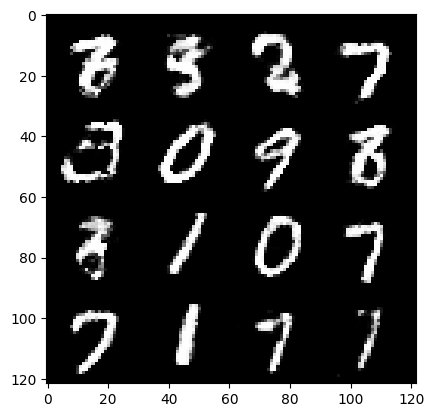

39 : step 18300, Generator loss : 1.6973480653762818, Discriminator Loss : 0.40058121552069986


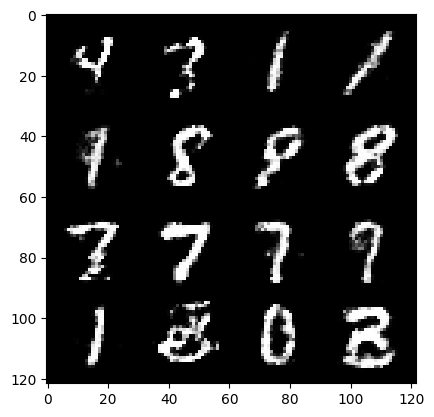

39 : step 18600, Generator loss : 1.731593392093976, Discriminator Loss : 0.3905945960680642


  0%|          | 0/469 [00:00<?, ?it/s]

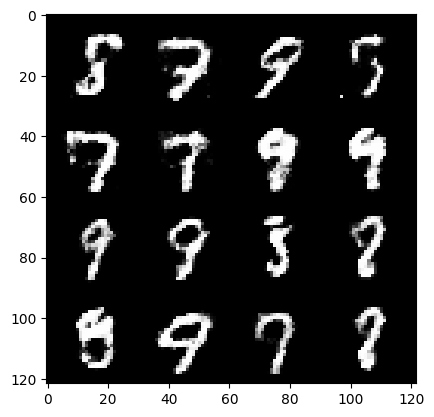

40 : step 18900, Generator loss : 1.7510110408067716, Discriminator Loss : 0.3926080002387365


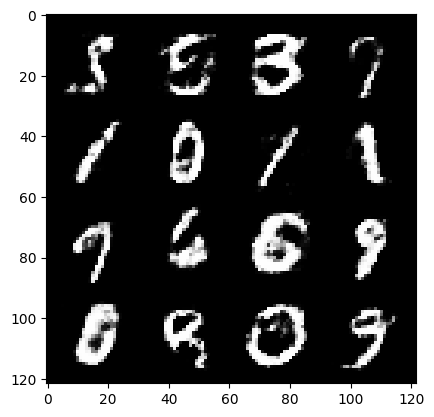

40 : step 19200, Generator loss : 1.7323997422059372, Discriminator Loss : 0.3931900306542714


  0%|          | 0/469 [00:00<?, ?it/s]

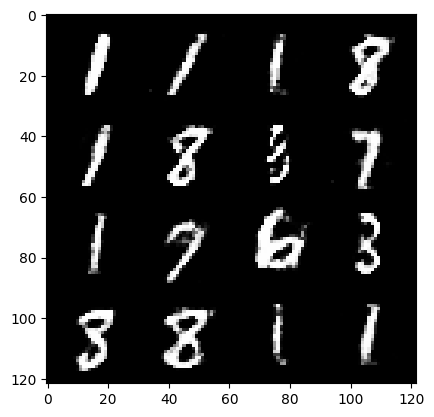

41 : step 19500, Generator loss : 1.7564440216620767, Discriminator Loss : 0.3865380360682805


  0%|          | 0/469 [00:00<?, ?it/s]

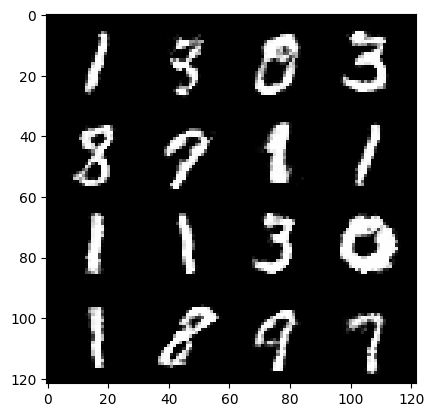

42 : step 19800, Generator loss : 1.820063860019047, Discriminator Loss : 0.38294075081745776


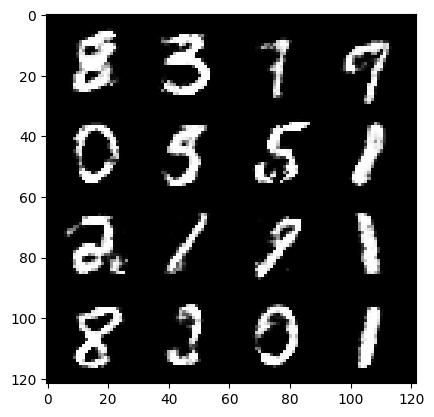

42 : step 20100, Generator loss : 1.7823588025569934, Discriminator Loss : 0.38516872137784947


  0%|          | 0/469 [00:00<?, ?it/s]

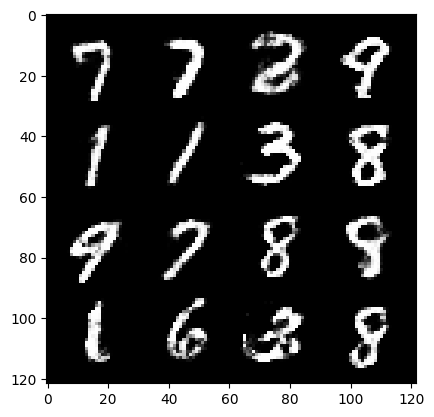

43 : step 20400, Generator loss : 1.7884869372844694, Discriminator Loss : 0.38091027826070795


  0%|          | 0/469 [00:00<?, ?it/s]

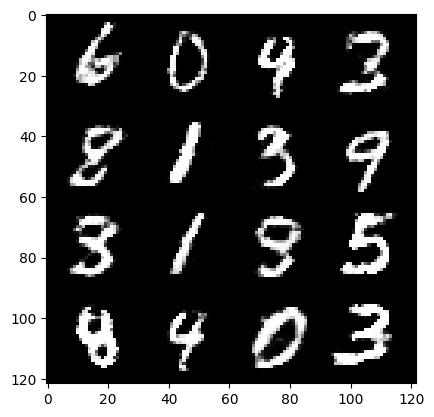

44 : step 20700, Generator loss : 1.838177526195843, Discriminator Loss : 0.37773457149664547


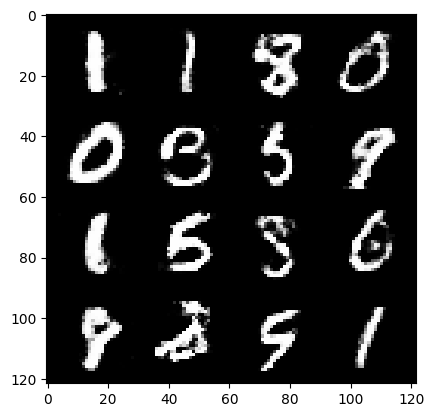

44 : step 21000, Generator loss : 1.8449344956874847, Discriminator Loss : 0.37292791018883387


  0%|          | 0/469 [00:00<?, ?it/s]

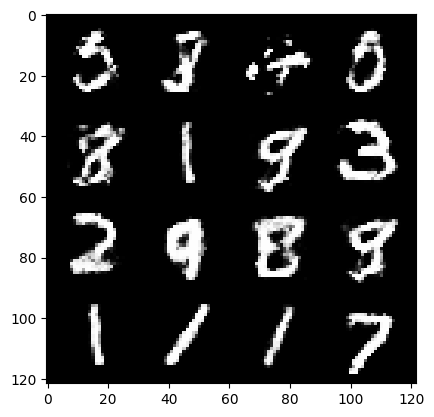

45 : step 21300, Generator loss : 1.828755670984589, Discriminator Loss : 0.37857749640941657


  0%|          | 0/469 [00:00<?, ?it/s]

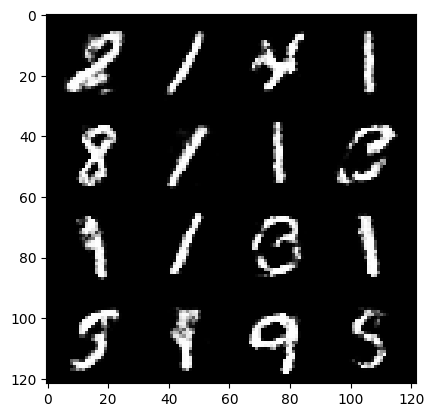

46 : step 21600, Generator loss : 1.8186255411307024, Discriminator Loss : 0.38068299174308773


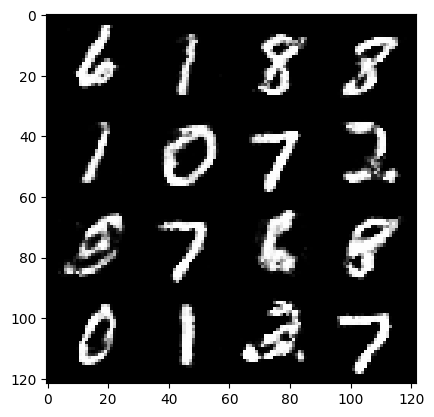

46 : step 21900, Generator loss : 1.840790036122003, Discriminator Loss : 0.3740841793020569


  0%|          | 0/469 [00:00<?, ?it/s]

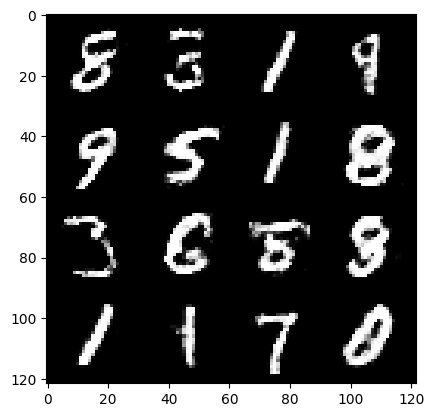

47 : step 22200, Generator loss : 1.8747345729668943, Discriminator Loss : 0.3667890396714211


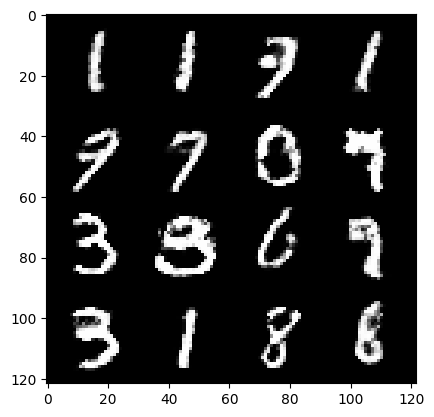

47 : step 22500, Generator loss : 1.8616654121875758, Discriminator Loss : 0.3694437626997631


  0%|          | 0/469 [00:00<?, ?it/s]

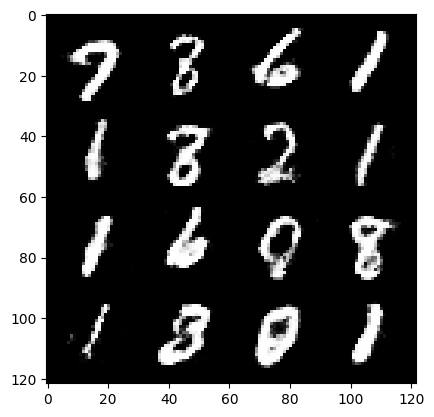

48 : step 22800, Generator loss : 1.8401014864444731, Discriminator Loss : 0.37003659566243524


  0%|          | 0/469 [00:00<?, ?it/s]

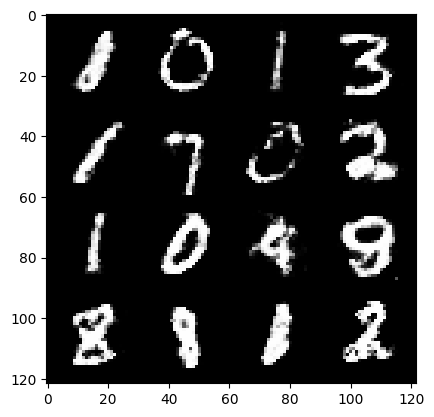

49 : step 23100, Generator loss : 1.8750614492098505, Discriminator Loss : 0.36816511114438405


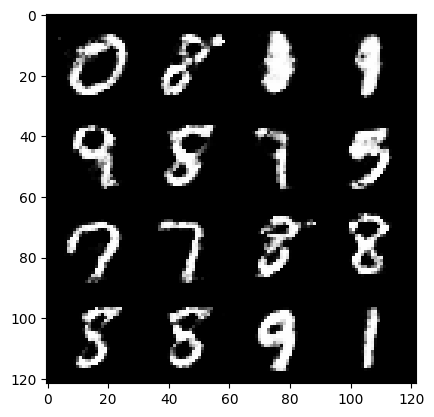

49 : step 23400, Generator loss : 1.9116606080532084, Discriminator Loss : 0.3632405003905295


In [ ]:
for epoch in range(cycles):
  for real, _ in tqdm(dataloader):

    disc_opt.zero_grad()
    current_bs = len(real)
    real = real.view(current_bs, -1).to(device)
    d_loss = disc_loss(z_dim, gen, disc, bs, loss_func, real)
    d_loss.backward()
    disc_opt.step()

    gen_opt.zero_grad()
    g_loss = gen_loss(z_dim, gen, disc, bs, loss_func)
    g_loss.backward()
    gen_opt.step()

    mean_disc_loss += d_loss.item() / info_step
    mean_gen_loss += g_loss.item() / info_step



    if(cur_step%info_step==0 and cur_step > 0):
      noise = gen_noise(current_bs, z_dim)
      fake = gen(noise)
      show(fake)
      print(f"{epoch} : step {cur_step}, Generator loss : {mean_gen_loss}, Discriminator Loss : {mean_disc_loss}")
      mean_gen_loss, mean_disc_loss = 0, 0

    cur_step += 1




Output of the generator : 


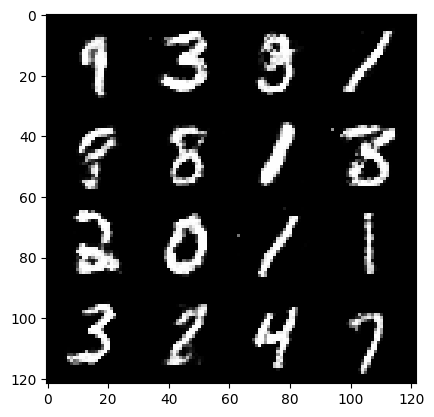

In [ ]:
noise = gen_noise(current_bs, z_dim)
fake = gen(noise)

print("Output of the generator : ")
show(fake)